In [1]:
import cv2, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Load Parameters

In [2]:
from utils import read_json

params = read_json('parameters.json')

RESIZE_X = params['resize']['x']
RESIZE_Y = params['resize']['y']
ITEM_FOLDER = params['item_folder']

## Input Data
* Image of the bin
* List of items in the bin

In [3]:
bin_stamp = '170405145336'
contents = ["Colgate_Toothbrush_4PK","Epsom_Salts","Duct_Tape",
            "Bath_Sponge","Crayons","Burts_Bees_Baby_Wipes"]

In [3]:
bin_stamp = '170405145538'
contents = ["glue_sticks","tissue_box","laugh_out_loud_jokes",
            "toilet_brush","expo_eraser","table_cloth"]

In [4]:
contents = [s.lower() for s in contents]

## Phase 0: Mask background by depth?

## Phase 1: Recognition by SIFT Features
### Compute Features in Bin

1067 features detected in bin


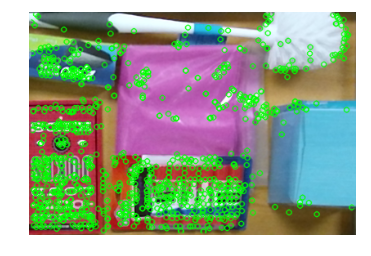

In [5]:
from utils import imread_rgb, compute_sift, draw_keypoints

filename_bin = 'bin/' + bin_stamp + '.png'
image_bin = imread_rgb(filename_bin)
(kp_bin, des_bin) = compute_sift(image_bin)
print('%d features detected in bin' % len(kp_bin))
draw_keypoints(image_bin,kp_bin)

### Match Bin and Items Features

In [6]:
from utils import read_features_from_file, read_bbox_from_file, unpack_keypoint, calc_matches

items = list(contents)

Item: "Training_items/glue_sticks/glue_sticks_top_01_sift.npy" Good features: 5
Item: "Training_items/tissue_box/tissue_box_top_01_sift.npy" Good features: 3
Item: "Training_items/laugh_out_loud_jokes/laugh_out_loud_jokes_top_01_sift.npy" Good features: 12
Item: "Training_items/toilet_brush/toilet_brush_top_01_sift.npy" Good features: 2
Item: "Training_items/expo_eraser/expo_eraser_top_01_sift.npy" Good features: 26
Item: "Training_items/table_cloth/table_cloth_top_01_sift.npy" Good features: 3


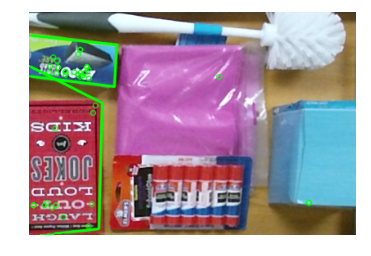

In [7]:
item_d = {}
recognised_items = []
image_disp = image_bin.copy()
mask_bin = np.zeros(image_bin.shape[0:2]).astype('uint8')
for item in items:
    prefix = ITEM_FOLDER + '/' + item + '/' + item
    filename = prefix + '_top_01_sift.npy'
    kp, des = read_features_from_file(filename)
    kp, des = unpack_keypoint(kp, des)
    des = des.astype('float32')
    good = calc_matches(des, des_bin)
    item_d[item] = {'file': filename, 'kp': kp, 'des': des, 'good': good}
    
    filename = prefix + '_bottom_01_sift.npy'
    kp, des = read_features_from_file(filename)
    kp, des = unpack_keypoint(kp, des)
    des = des.astype('float32')
    good = calc_matches(des, des_bin)
    if len(good) > len(item_d[item]['good']):
        item_d[item] = {'file': filename, 'kp': kp, 'des': des, 'good': good}

    print('Item: "%s" Good features: %d' % (item_d[item]['file'], 
                                          len(item_d[item]['good'])))
    MIN_MATCH_COUNT=10
    kp = item_d[item]['kp']
    good = item_d[item]['good']
    if len(good) > MIN_MATCH_COUNT:
        dst_pts = [ kp_bin[m.trainIdx] for m in good ]
        image_disp = cv2.drawKeypoints(image_disp,dst_pts,color=(0,255,0))
        recognised_items.append(item)
        src_pts = np.float32([ kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_bin[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        x, y, w, h = read_bbox_from_file(item_d[item]['file'][:-9] + '_bbox.json')
        pts = np.float32([ [x,y],[x,y+h-1],[x+w-1,y+h-1],[x+w-1,y] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        cv2.polylines(image_disp,[np.int32(dst)],True,(0,255,0),2, cv2.CV_AA)
        cv2.fillConvexPoly(mask_bin,np.int32(dst),(255,))

plt.imshow(image_disp), plt.axis('off');

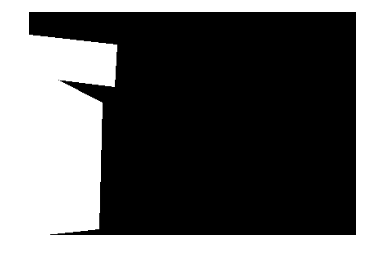

In [8]:
plt.imshow(mask_bin,cmap='gray'), plt.axis('off');

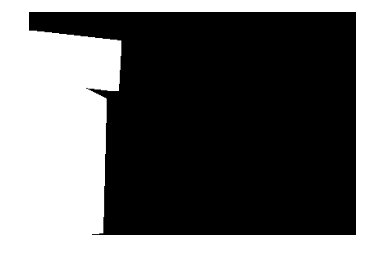

In [9]:
kernel = np.ones((3,3),np.uint8)
mask_bin = cv2.dilate(mask_bin,kernel,iterations = 5)
plt.imshow(mask_bin,cmap='gray'), plt.axis('off');

## Phase 2: Recognition by Color

In [10]:
%%time
from sklearn.cluster import KMeans, MiniBatchKMeans

n_cc = 20
image_RGBA = np.dstack((image_bin, 255-mask_bin))
pixels = image_RGBA.reshape((image_RGBA.shape[0] * image_RGBA.shape[1], 4))
filtered_pixels = np.array(filter(lambda x:x[3]==255,pixels))
n, _ = filtered_pixels.shape
pixels_LAB = cv2.cvtColor(filtered_pixels[:,0:3].reshape(1,n,3),cv2.COLOR_RGB2LAB)
pixels_LAB = pixels_LAB.reshape(n,3)
#clt = MiniBatchKMeans(n_clusters = n_cc)
clt = KMeans(n_clusters = n_cc)
clt.fit(pixels_LAB)

CPU times: user 6.12 s, sys: 136 ms, total: 6.25 s
Wall time: 6.26 s


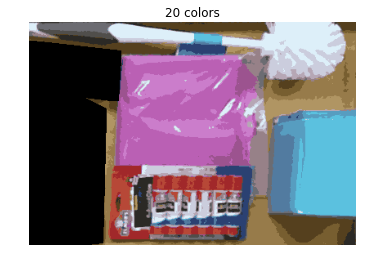

In [11]:
image = cv2.cvtColor(image_bin, cv2.COLOR_RGB2LAB)
(h_bin, w_bin) = image.shape[:2]
pixels = image.reshape((image.shape[0] * image.shape[1], 3))
labels = clt.predict(pixels)
quant = clt.cluster_centers_.astype("uint8")[labels]
quant = quant.reshape((h_bin, w_bin, 3))
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2RGB)
#plt.subplot(121),plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=255-mask_bin)),plt.title('Original'),plt.axis('off');
#plt.subplot(122),plt.imshow(cv2.bitwise_and(quant,quant,mask=255-mask_bin)),plt.title('%d colors' % n_cc),plt.axis('off');
plt.imshow(cv2.bitwise_and(quant,quant,mask=255-mask_bin)),plt.title('%d colors' % n_cc),plt.axis('off');
bin_cc = clt.cluster_centers_

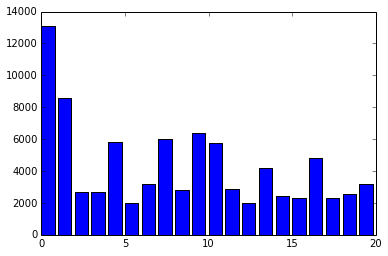

In [12]:
bin_hist, _ = np.histogram(clt.predict(pixels_LAB),bins=range(n_cc+1))
plt.bar(range(n_cc), bin_hist);

In [13]:
sort_index = np.argsort(bin_hist)[::-1]
sort_index

array([ 0,  1,  9,  7,  4, 10, 16, 13, 19,  6, 11,  8,  2,  3, 18, 14, 15,
       17,  5, 12])

In [14]:
recognised_items

['laugh_out_loud_jokes', 'expo_eraser']

In [15]:
items = [s for s in contents if s not in recognised_items]
items

['glue_sticks', 'tissue_box', 'toilet_brush', 'table_cloth']

In [16]:
positions = []
weights = []

### While not sort_index is empty

In [42]:
obj_label = sort_index[0]
d_other = [np.linalg.norm(bin_cc[obj_label,1:]-bin_cc[other,1:]) for other in sort_index]
obj_labels = [sort_index[idx] for idx,val in enumerate(d_other) if val<20]
obj_labels

[14]

In [43]:
# Weighting the histogram of dominant colors 
obj_hist = np.array([bin_hist[obj_l] for obj_l in obj_labels],dtype='float32')
obj_hist = obj_hist / np.sum(obj_hist)
obj_hist

array([ 1.], dtype=float32)

In [44]:
sort_index = np.array([x for x in sort_index if x not in obj_labels])
sort_index

array([], dtype=float64)

[(677.0, (230, 177, 43, 42))]

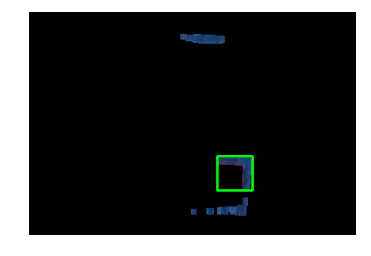

In [45]:
mask = np.zeros((h_bin, w_bin)).astype('uint8')
for val_label in obj_labels:
    mask = cv2.bitwise_or( mask, ((labels==val_label).astype('uint8') * 255).reshape((h_bin, w_bin)) )
mask = cv2.bitwise_and( mask, 255-mask_bin)
kernel = np.ones((3,3),np.uint8)
mask = cv2.erode(mask,kernel,iterations = 3)
mask = cv2.dilate(mask,kernel,iterations = 3)

image_disp = cv2.bitwise_and(image_bin,image_bin,mask=mask)
cnt, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt = sorted(cnt, key=lambda x:cv2.contourArea(x), reverse=True)
best_pos = []
try:
    i = 0
    while cv2.contourArea(cnt[i]) > 500:
        x,y,w,h = cv2.boundingRect(cnt[i])
        cv2.rectangle(image_disp,(x,y),(x+w,y+h),(0,255,0),2)
        best_pos.append((cv2.contourArea(cnt[i]),cv2.boundingRect(cnt[i])))
        i += 1
except IndexError:
    pass
plt.imshow(image_disp); plt.axis('off');
positions.append(best_pos)
best_pos

In [46]:
best_item = []
views = ['top_01','top-side_01','top-side_02','bottom_01','bottom-side_01','bottom-side_02']
for item in items:
    for view in views:
        try:
            filename = ITEM_FOLDER + '/' + item + '/' + item + '_' + view + '_dc.json'
            dc = read_json(filename)
            hist = dc['hist']
            obj_cc = dc['cluster_centers']
            sum_h = 0
            for i in range(5):
                d_bin_obj = [np.linalg.norm(obj_cc[i]-bin_cc[obj_l,:]) for obj_l in obj_labels]
                index_min = np.argmin(d_bin_obj)
                if d_bin_obj[index_min] < 25:
                    sum_h += hist[i] * obj_hist[index_min]
                    # hist[i] is the number of pixels in the image -> count only in rectangle?
            if sum_h > 0.05:
                best_item.append((sum_h,item,view))
        except IOError:
            pass
#best_item = sorted(best_item,reverse=True)
#best_item
best_item_one = []
for it in items:
    try:
        w = max([bi[0] for bi in best_item if bi[1]==it])
        best_item_one.append((w,it))
    except ValueError:
        pass
weights.append(best_item_one)
best_item_one

[(0.10631583726843444, 'glue_sticks'),
 (0.068325997234449057, 'tissue_box'),
 (0.070148382493892464, 'table_cloth')]

### End While

In [47]:
positions

[[(21045.0, (106, 42, 172, 136))],
 [(12187.0, (296, 109, 103, 130))],
 [(5420.0, (287, 1, 112, 123)),
  (5291.5, (91, 213, 304, 60)),
  (1457.5, (168, 1, 122, 21)),
  (1330.0, (88, 97, 19, 147)),
  (847.0, (99, 27, 80, 14))],
 [(10239.0, (236, 1, 151, 212)),
  (5013.5, (116, 176, 144, 81)),
  (3986.0, (1, 1, 201, 28))],
 [(1678.0, (152, 189, 109, 18)),
  (1053.0, (101, 177, 36, 54)),
  (760.0, (148, 252, 106, 9))],
 [(677.0, (230, 177, 43, 42))]]

In [48]:
weights

[[(0.39915807172345996, 'table_cloth')],
 [(0.30610808432280878, 'tissue_box')],
 [],
 [(0.19411702097511635, 'glue_sticks'),
  (0.16388842842029816, 'tissue_box'),
  (0.18184010484484178, 'toilet_brush'),
  (0.11191457105008411, 'table_cloth')],
 [(0.084316054722079523, 'glue_sticks')],
 [(0.10631583726843444, 'glue_sticks'),
  (0.068325997234449057, 'tissue_box'),
  (0.070148382493892464, 'table_cloth')]]

Remove boxes with empty weights

In [49]:
bbox_ok = [(p[0][0],p[0][1],w[0][0],w[0][1]) for p,w in zip(positions,weights) if len(w)==1]

In [50]:
bbox_ok

[(21045.0, (106, 42, 172, 136), 0.39915807172345996, 'table_cloth'),
 (12187.0, (296, 109, 103, 130), 0.30610808432280878, 'tissue_box'),
 (1678.0, (152, 189, 109, 18), 0.084316054722079523, 'glue_sticks')]

In [51]:
items

['glue_sticks', 'tissue_box', 'toilet_brush', 'table_cloth']

In [52]:
best_bbox = []
for it in items:
    bbox_it = sorted([bb for bb in bbox_ok if bb[3]==it],key=lambda x:x[2],reverse=True)
    if bbox_it:
        best_bbox.append(bbox_it[0])

In [53]:
best_bbox

[(1678.0, (152, 189, 109, 18), 0.084316054722079523, 'glue_sticks'),
 (12187.0, (296, 109, 103, 130), 0.30610808432280878, 'tissue_box'),
 (21045.0, (106, 42, 172, 136), 0.39915807172345996, 'table_cloth')]

In [54]:
it_col = {'table_cloth':(255,0,255),'tissue_box':(0,255,255),'glue_sticks':(255,0,0),'toilet_brush':(255,255,0)}

In [55]:
new_pos = [p for p, w in zip(positions,weights) if len(w)>1]
new_wgt = [w for w in weights if len(w)>1]

In [56]:
new_pos

[[(10239.0, (236, 1, 151, 212)),
  (5013.5, (116, 176, 144, 81)),
  (3986.0, (1, 1, 201, 28))],
 [(677.0, (230, 177, 43, 42))]]

In [57]:
new_wgt

[[(0.19411702097511635, 'glue_sticks'),
  (0.16388842842029816, 'tissue_box'),
  (0.18184010484484178, 'toilet_brush'),
  (0.11191457105008411, 'table_cloth')],
 [(0.10631583726843444, 'glue_sticks'),
  (0.068325997234449057, 'tissue_box'),
  (0.070148382493892464, 'table_cloth')]]

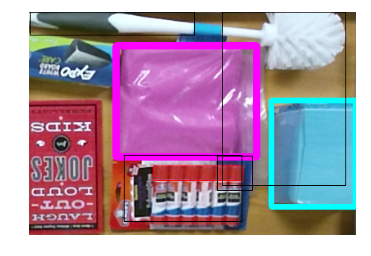

In [58]:
image_disp = image_bin.copy()
for bb in best_bbox:
        x, y, w, h = bb[1]
        cv2.rectangle(image_disp,(x,y),(x+w,y+h),it_col[bb[3]],int(20*bb[2]))
for p in new_pos:
    for a, bb in p:
        x, y, w, h = bb
        cv2.rectangle(image_disp,(x,y),(x+w,y+h),(0,0,0),1)
plt.imshow(image_disp); plt.axis('off');

In [59]:
def overlaps(bb1,bb2):
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2
    x_overlap = max(0, min(x1+w1,x2+w2) - max(x1,x2))
    y_overlap = max(0, min(y1+h1,y2+h2) - max(y1,y2))
    overlapArea = x_overlap * y_overlap
    return float(overlapArea) / (w1*h1)

In [60]:
def smaller(bb1,bb2):
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2
    if float(w1*h1) / (w2*h2) < 0.1:
        return True
    else:
        return False

In [61]:
other_bbox = []
unknw_bbox = []
for p,w in zip(new_pos,new_wgt):
    for xa,xbb in p:
        bb_over = []
        it_list = [it for _,it in w]
        for ia,ibb,iw,it in best_bbox:
            s = overlaps(xbb,ibb)
            if s > 0 and smaller(xbb,ibb):
                bb_over.append((s, xbb,it))
            else:
                it_list.remove(it)
        if bb_over:
            other_bbox.append(sorted(bb_over,reverse=True)[0])
        else:
            unknw_bbox.append((xbb,it_list)) # ambiguous items


In [62]:
other_bbox

[(0.023809523809523808, (230, 177, 43, 42), 'table_cloth')]

In [63]:
unknw_bbox

[((236, 1, 151, 212), ['toilet_brush']),
 ((116, 176, 144, 81), ['toilet_brush']),
 ((1, 1, 201, 28), ['toilet_brush'])]

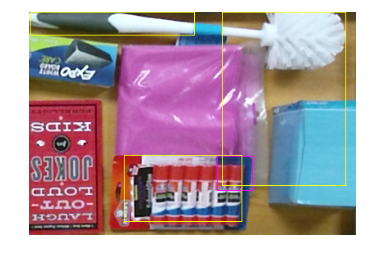

In [64]:
image_disp = image_bin.copy()
for bb in other_bbox:
        x, y, w, h = bb[1]
        cv2.rectangle(image_disp,(x,y),(x+w,y+h),it_col[bb[2]],int(1))
for bb in unknw_bbox:
        x, y, w, h = bb[0]
        cv2.rectangle(image_disp,(x,y),(x+w,y+h),it_col[bb[1][0]],int(1))
plt.imshow(image_disp); plt.axis('off');

In [126]:
l.remove('b')

In [127]:
l

['a', 'c']

In [ ]:

# for each position, weight
# if weight is empty:
#    position <- unknown
# if weight contains 1 item:
#    position <- item
#    merge all bbox of same color in a single bbox

# remove overlapping ambiguous bbox


In [64]:
#item = 'table_cloth'
#item = 'tissue_box'
#item = 'glue_sticks'
item = 'toilet_brush'

poses = []
for idx, val in enumerate(weights):
    w = [elem[0] for elem in val if elem[1]==item]
    if w:
        poses.append((w[0],positions[idx]))

In [65]:
poses

[(0.26748957393484069,
  [(6495.5, (236, 1, 151, 70)),
   (1666.0, (98, 3, 104, 24)),
   (560.0, (54, 1, 42, 17)),
   (557.5, (264, 95, 27, 40)),
   (515.5, (138, 176, 46, 15))])]

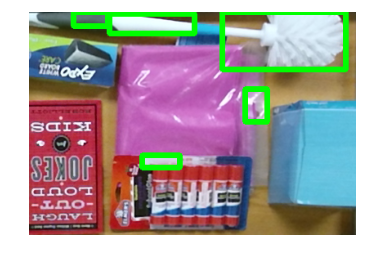

In [66]:
image_disp = image_bin.copy()
for p in poses:
    for bb in p[1]:
        x, y, w, h = bb[1]
        cv2.rectangle(image_disp,(x,y),(x+w,y+h),(0,255,0),int(20*p[0]))
plt.imshow(image_disp); plt.axis('off');

In [ ]:
# Intersection of rectangles of two different colors

In [ ]:
# if only one bbox, include it